# Random forest model

This is the basic one-class (attack/no-attack) random forest. 
I did a little grid-searching to make sure, but most of the defaults were great.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score
from sklearn.metrics import balanced_accuracy_score, matthews_corrcoef, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.pipeline import make_pipeline as imb_make_pipeline

from mlxtend.plotting import plot_confusion_matrix
from scikitplot.estimators import plot_feature_importances

from consistent_labels import get_attack_labels
from data_read import data_read

In [2]:
%load_ext watermark
%watermark -iv -p sklearn,mlxtend,imblearn,scikitplot

numpy      1.15.4
pandas     0.24.0
matplotlib 3.0.2
sklearn 0.20.2
mlxtend 0.15.0.0
imblearn 0.4.3
scikitplot 0.3.7


In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Scoring function 

The balanced_accuracy_score, adjusted for beating random with unbalanced classes 
is my optimization target.

In [4]:
acc_scoring = make_scorer(balanced_accuracy_score, adjusted=True)

# Random Forest - 1 class problem

In [5]:
df = data_read('train', 'fixed')
y = df.label
X = df.drop(columns=['label','attack_cat'])

In [6]:
y.value_counts()

0    1331257
1     192774
Name: label, dtype: int64

In [7]:
n_estimators = [ 200 ] 
max_features = [ 8 ]
min_samples_split = [ 2  ]
min_samples_leaf = [ 2 ]
oob_score = [ True ]

param_grid = {
    'n_estimators':n_estimators,
    'max_features':max_features,
    'min_samples_split':min_samples_split,
    'min_samples_leaf':min_samples_leaf,
    'oob_score':oob_score
}

rf = BalancedRandomForestClassifier( 
                            n_jobs=-1,  
                            random_state=5,
                            replacement=True)

clf = GridSearchCV( rf, 
                    param_grid,
                    scoring = acc_scoring,
                    cv = 3,
                    verbose = True,
                   return_train_score = False
                   )
    

cross1 = clf.fit(X, y)
    

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.2min finished


In [8]:
pd.DataFrame(cross1.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,param_oob_score,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,81.623946,2.523068,2.281131,0.10388,8,2,2,200,True,"{'max_features': 8, 'min_samples_leaf': 2, 'mi...",0.985982,0.986083,0.986312,0.986126,0.000138,1


In [9]:
cross1.best_params_

{'max_features': 8,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 200,
 'oob_score': True}

In [10]:
# Because we downsampled, there's unseen data even
# in the train set, so test against both train and test

In [11]:
y_pred = clf.predict(X)
roc = roc_auc_score( y, y_pred ) 
acc = balanced_accuracy_score(y, y_pred, adjusted=True) 
print('roc = ', roc)
print('acc = ', acc)

roc =  0.9934367957633464
acc =  0.9868735915266926


[[1313810   17447]
 [      4  192770]]


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a1a1f14e0>)

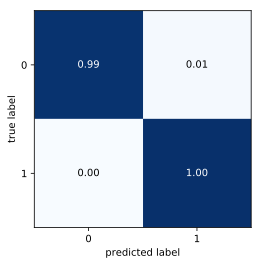

In [12]:
cm = confusion_matrix(y, y_pred)
print(cm)
plot_confusion_matrix(cm, show_absolute=False, show_normed=True)

In [13]:
test = data_read('test', 'fixed').drop(columns='attack_cat')
    
y_pred = clf.predict( test.drop(columns='label') )
roc = roc_auc_score( test.label, y_pred ) 
acc = balanced_accuracy_score(test.label, y_pred, adjusted=True) 
print('roc = ', roc)
print('acc = ', acc)

roc =  0.9932968456194071
acc =  0.9865936912388147


[[875889  11615]
 [    41 128468]]


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a1bf00c18>)

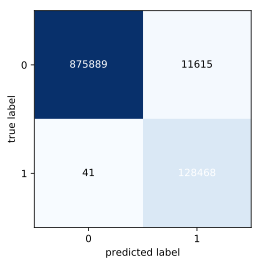

In [14]:
cm = confusion_matrix(test.label, y_pred)
print(cm)
plot_confusion_matrix(cm, show_absolute=True, show_normed=False)

In [15]:
probs = clf.predict_proba( test.drop(columns='label'))

In [16]:
from sklearn.metrics import roc_curve
fpr, tpr, thresh = roc_curve(test.label, probs[:,1], 
                             pos_label=1)

In [17]:
from mlxtend.plotting.remove_chartjunk import remove_borders

/Users/jlc/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


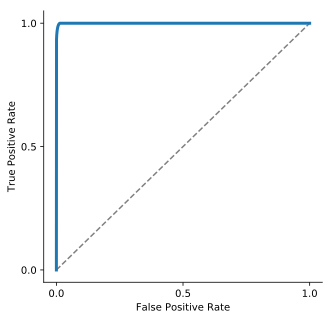

In [18]:
fig, ax = plt.subplots(figsize=(5,5))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.plot(fpr, tpr, linewidth=3 )
ax = plt.gca()
remove_borders([ax])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xticks([0,0.5,1.0])
plt.yticks([0,0.5,1.0])
plt.savefig('roc.svg')
plt.show()

In [19]:
fi  = clf.best_estimator_.feature_importances_
names = test.drop(columns='label').columns
feature_importances = pd.Series(data=fi, index=names)
feature_importances = feature_importances.sort_values(ascending=False)
feature_importances

sttl                0.267179
ct_state_ttl        0.250913
dload               0.104314
state_INT           0.070022
dmeansz             0.057531
dttl                0.057454
smeansz             0.033474
avgdpk              0.028932
dintpkt             0.026568
synack              0.017716
ackdat              0.016490
sload               0.016017
sintpkt             0.013554
dur                 0.009824
ct_srv_dst          0.005038
djit                0.004951
ct_dst_src_ltm      0.003629
ct_srv_src          0.003115
avg_port_ltm        0.002828
sjit                0.001657
avgspk              0.001360
ct_dst_ltm          0.001255
ct_src_ltm          0.000997
avgwin              0.000900
proto_other         0.000834
proto_udp           0.000781
proto_arp           0.000687
state_CON           0.000683
is_sm_ips_ports     0.000492
res_bdy_len         0.000276
state_REQ           0.000211
ct_flw_http_mthd    0.000172
trans_depth         0.000101
proto_ospf          0.000022
ct_ftp_cmd    

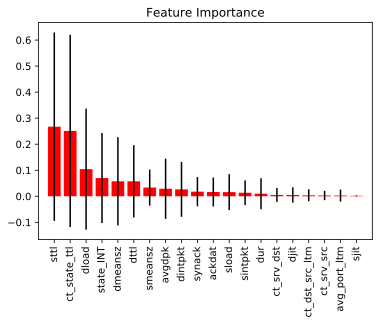

In [20]:
plot_feature_importances(clf.best_estimator_, feature_names=X.columns, x_tick_rotation=90)